In [7]:
from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import BasicAer
from qiskit import execute
%matplotlib inline 

In [8]:
def create_eigs(matrix, num_auxiliary, num_time_slices, negative_evals):
    ne_qfts = [None, None]
    if negative_evals:
        num_auxiliary += 1
        ne_qfts = [QFT(num_auxiliary - 1), QFT(num_auxiliary - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_auxiliary).inverse(),
                   num_time_slices=num_time_slices,
                   num_ancillae=num_auxiliary,
                   expansion_mode='suzuki',
                   expansion_order=2,
                   evo_time=None,  # This is t, can set to: np.pi*3/4
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)

In [9]:
matrix = [[1, -1/3], [-1/3, 1]]
vector = [1, 0]

print('Input Matrix:',matrix)
e,v=np.linalg.eig(matrix)

print('\nExpected Eigen Values:',e)

Input Matrix: [[1, -0.3333333333333333], [-0.3333333333333333, 1]]

Expected Eigen Values: [1.33333333 0.66666667]


In [11]:
orig_size = len(vector)
matrix, vector, truncate_powerdim, truncate_hermitian = HHL.matrix_resize(matrix, vector)

# Initialize eigenvalue finding module
print('Matrix after resize:\n',matrix)
eigs = create_eigs(matrix, 3, 50, False)
num_q, num_a = eigs.get_register_sizes()

q = QuantumRegister(num_q, name="io")
qc = QuantumCircuit(q)

qc += eigs.construct_circuit("circuit", q)
a = eigs._output_register


c = ClassicalRegister(3)
qc.add_register(c)
qc.measure(a, c)


Matrix after resize:
 [[ 1.         -0.33333333]
 [-0.33333333  1.        ]]





Circuit:


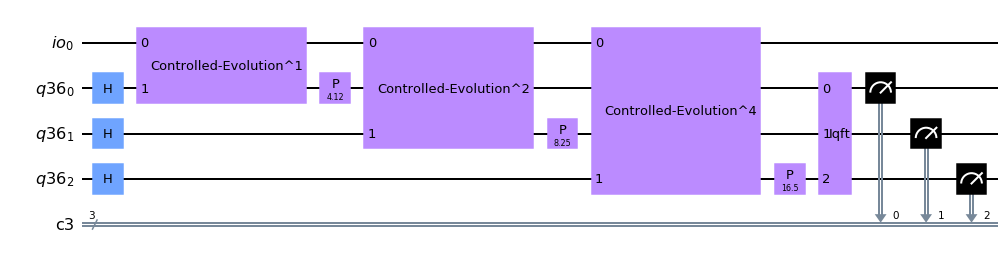

In [12]:
print('\n\n\nCircuit:')
qc.draw(output='mpl')

In [13]:
#Simulate circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend,shots=4321)
result= job.result()


counts = result.get_counts()

print('\n\nResult:',result)
print('\n\nCount:',counts)



Result: Result(backend_name='qasm_simulator', backend_version='2.0.0', qobj_id='951e45ff-723e-491a-9782-f31e4d794e3e', job_id='7007dfd5-74a6-4d45-b27e-43c0ffa62080', success=True, results=[ExperimentResult(shots=4321, success=True, meas_level=MeasLevel.CLASSIFIED, data=ExperimentResultData(counts={'0x1': 852, '0x2': 98, '0x7': 2246, '0x6': 882, '0x3': 42, '0x0': 41, '0x4': 49, '0x5': 111}), header=QobjExperimentHeader(clbit_labels=[['c3', 0], ['c3', 1], ['c3', 2]], creg_sizes=[['c3', 3]], global_phase=0.0, memory_slots=3, n_qubits=4, name='circuit84277', qreg_sizes=[['io', 1], ['q36', 3]], qubit_labels=[['io', 0], ['q36', 0], ['q36', 1], ['q36', 2]]), status=DONE, name='circuit84277', seed_simulator=1390824950, time_taken=0.3964273929595947)], status=COMPLETED, status=QobjHeader(backend_name='qasm_simulator', backend_version='2.0.0'), time_taken=0.3964273929595947)


Count: {'001': 852, '010': 98, '111': 2246, '110': 882, '011': 42, '000': 41, '100': 49, '101': 111}
